In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

from src.recipro_cam import ReciproCam
from util.util import overlay_heatmap


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Test with: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)


Test with: cpu


Recipro CAM Execution Time: 0.5091860294342041:21


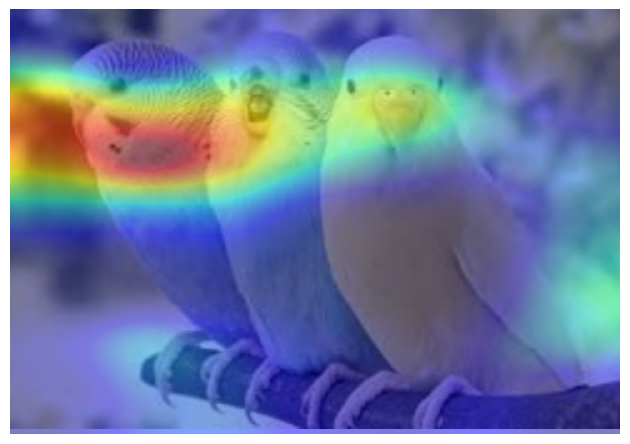

In [2]:
# Single input image CAM test
input_file_name = './data/bird_image1.png'
img = Image.open(input_file_name)
input_tensor = transform(img).unsqueeze(0)
input_tensor = input_tensor.to(device)

begin_time = time.time()
recipro_cam = ReciproCam(model, device=device)
cam, class_id = recipro_cam(input_tensor)
last_time = time.time()
execution_time = last_time - begin_time
print(f'Recipro CAM Execution Time: {execution_time}:{class_id}')

img = np.asarray(img)
result = overlay_heatmap(to_pil_image(img), to_pil_image(cam.detach(), mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
filename = f'./cam_results/single_image_cam.png'
result.save(filename)

Recipro CAM Execution Time: 0.9426450729370117:21


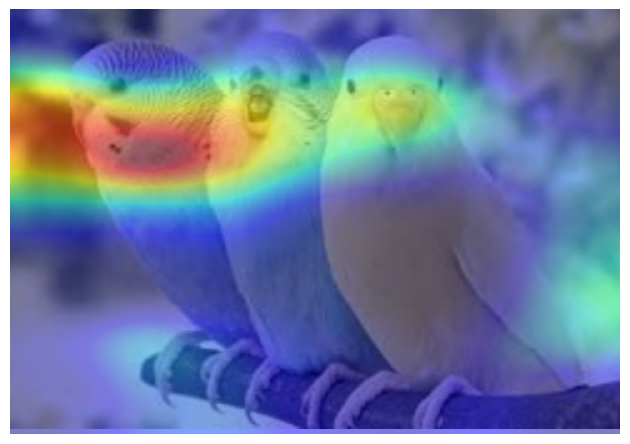

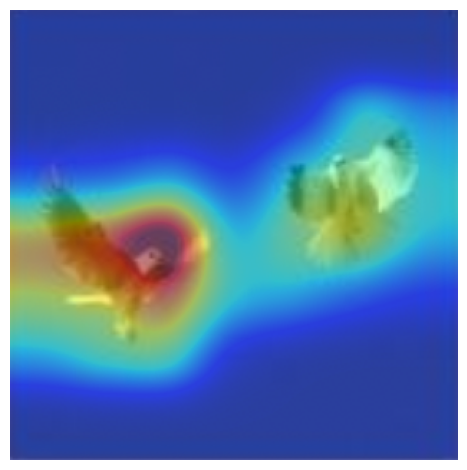

In [3]:
# Multiple input images CAM test
input_file_names = ['./data/bird_image1.png',
                    './data/bird_image2.png']
images = []
for i in range(len(input_file_names)):
    img = Image.open(input_file_names[i])
    images.append(img)
    i_tensor = transform(img).unsqueeze(0)
    if i > 0:
        input_tensor = torch.cat((input_tensor, i_tensor), dim=0)
    else:
        input_tensor = i_tensor
input_tensor = input_tensor.to(device)

begin_time = time.time()
recipro_cam = ReciproCam(model, device=device)
cam, class_id = recipro_cam(input_tensor)
last_time = time.time()
execution_time = last_time - begin_time
print(f'Recipro CAM Execution Time: {execution_time}:{class_id}')

for i in range(len(cam)):
    img = np.asarray(images[i])
    result = overlay_heatmap(to_pil_image(img), to_pil_image(cam[i].detach(), mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
    filename = f'./cam_results/test{i}.png'
    result.save(filename)

